In [72]:
pip install numpy scikit-learn geopandas folium seaborn matplotlib psycopg2-binary pandas ipywidgets > /dev/null 2>&1 || echo "Error: pip install failed"

Note: you may need to restart the kernel to use updated packages.


In [73]:
import psycopg2
import json
import pandas as pd
from sqlalchemy import create_engine
import matplotlib.pyplot as plt
import folium
from folium.plugins import HeatMap
import seaborn as sns

In [74]:
# Database connection details
db_user = "airflow"
db_password = "airflow"
db_host = "postgres"
db_port = "5432"
db_name = "airflow"


In [75]:
# Create a database engine
engine = create_engine(f"postgresql://{db_user}:{db_password}@{db_host}:{db_port}/{db_name}")

# Query the stg_open_issues_df view
query = "SELECT * FROM stg_issues;"

# Load the data into a pandas DataFrame
i = pd.read_sql_query(query, engine)



In [76]:
# List of specific request_type_titles
target_titles = [
    'Homeless Encampment and Requests for Outreach',
    'Someone Living on PUBLIC PROPERTY in Motor Home/Vehicle on Street',
    'Someone Living in Garage/Shed or Yard'
]

# Add a new column to denote if the request_type_title is in the list
i['is_homeless_related'] = i['request_type_title'].isin(target_titles)


In [101]:
# Filter open open_issues_df where issue_closed_at is NaN and make a copy
open_issues_df = i[i['issue_closed_at'].isna()].copy()

# Use .loc to set the 'ticket_age_days' column safely
open_issues_df['ticket_age_days'] = (pd.Timestamp.now() - open_issues_df['issue_created_at']).dt.days

# Get top request types
top_request_types = open_issues_df['request_type_title'].value_counts()

# Get top assignees
top_assignees = open_issues_df['assignee'].value_counts()

# Calculate average age of open tickets by request type
avg_age_by_request_type = open_issues_df.groupby('request_type_title')['ticket_age_days'].mean().sort_values(ascending=False)

# Get counts by request type
counts_by_request_type = open_issues_df['request_type_title'].value_counts()

# Summary table: total open open_issues_df and average age by request type
summary_table = open_issues_df.groupby('request_type_title').agg(
    total_open=('issue_id', 'count'),
    avg_age=('ticket_age_days', 'mean')
).sort_values(by='total_open', ascending=False)


TypeError: 'int' object is not subscriptable

In [78]:
# # 1. Basic Overview
# stg_open_issues_df_df = open_issues_df
# print("Shape of the DataFrame:", stg_open_issues_df_df.shape)
# print("\nColumns and Data Types:\n", stg_open_issues_df_df.dtypes)
# print("\nSample Rows:\n", stg_open_issues_df_df.head())

# # 2. Descriptive Statistics for Numeric Columns
# print("\nDescriptive Statistics:\n", stg_open_issues_df_df.describe())

# # 3. Check for Missing Data
# print("\nMissing Data:\n", stg_open_issues_df_df.isnull().sum())

# # 4. Distribution of Issue Status
# print("\nDistribution of Status:\n", stg_open_issues_df_df['status'].value_counts())

# # 5. If there's a 'test_name' column, you can analyze it as well
# if 'test_name' in stg_open_issues_df_df.columns:
#     print("\nDistribution of Test Names:\n", stg_open_issues_df_df['test_name'].value_counts())


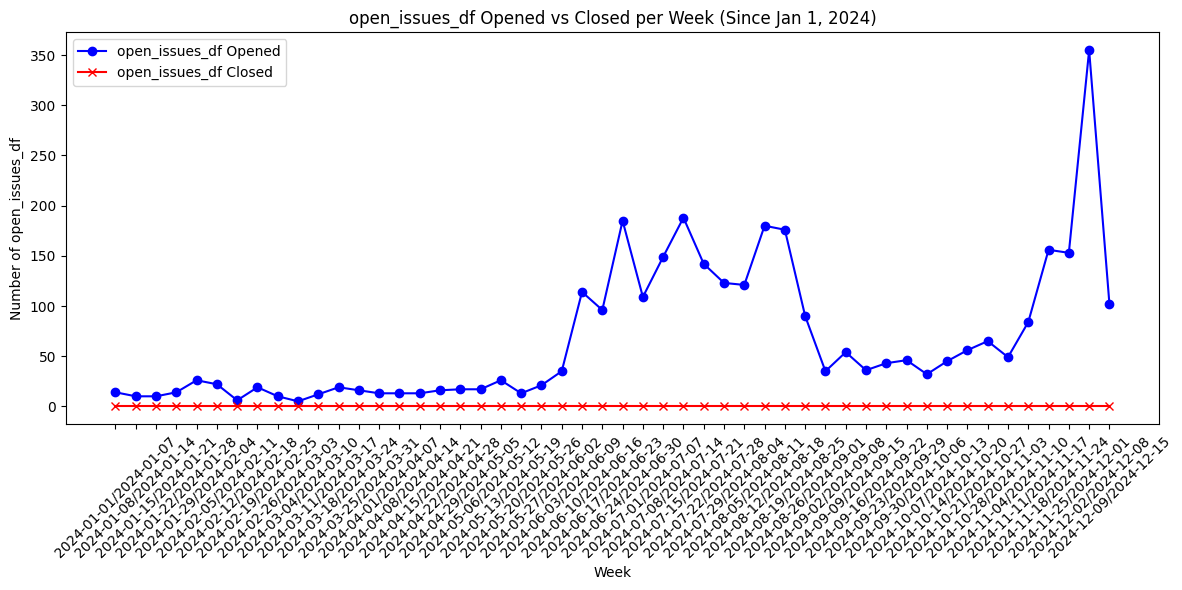

In [79]:
# Ensure 'issue_created_at' is in datetime format and make a copy to avoid SettingWithCopyWarning
open_issues_df['issue_created_at'] = pd.to_datetime(open_issues_df['issue_created_at'])

# Filter the DataFrame for open_issues_df created on or after '2024-01-01' and create a copy
stg_open_issues_df_df = open_issues_df[open_issues_df['issue_created_at'] >= '2024-01-01'].copy()

# Ensure 'issue_created_at' and 'issue_closed_at' are in datetime format
stg_open_issues_df_df['issue_created_at'] = pd.to_datetime(stg_open_issues_df_df['issue_created_at'])
stg_open_issues_df_df['issue_closed_at'] = pd.to_datetime(stg_open_issues_df_df['issue_closed_at'], errors='coerce')  # Some may be null

# Filter data to include only open_issues_df opened or closed from January 1, 2024
start_date = '2024-01-01'
stg_open_issues_df_df = stg_open_issues_df_df[(stg_open_issues_df_df['issue_created_at'] >= start_date) | 
                               (stg_open_issues_df_df['issue_closed_at'] >= start_date)]

# Use .loc to avoid the SettingWithCopyWarning
stg_open_issues_df_df.loc[:, 'created_week'] = stg_open_issues_df_df['issue_created_at'].dt.to_period('W')
stg_open_issues_df_df.loc[:, 'closed_week'] = stg_open_issues_df_df['issue_closed_at'].dt.to_period('W')

# Count the number of open_issues_df opened and closed each week
opened_weekly = stg_open_issues_df_df.groupby('created_week').size()
closed_weekly = stg_open_issues_df_df.dropna(subset=['closed_week']).groupby('closed_week').size()

# Merge the data for plotting
weekly_data = pd.DataFrame({'opened': opened_weekly, 'closed': closed_weekly}).fillna(0)

# Plotting the chart
plt.figure(figsize=(12, 6))
plt.plot(weekly_data.index.astype(str), weekly_data['opened'], label='open_issues_df Opened', color='b', marker='o')
plt.plot(weekly_data.index.astype(str), weekly_data['closed'], label='open_issues_df Closed', color='r', marker='x')

plt.title('open_issues_df Opened vs Closed per Week (Since Jan 1, 2024)')
plt.xlabel('Week')
plt.ylabel('Number of open_issues_df')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()

# Show the plot
plt.show()


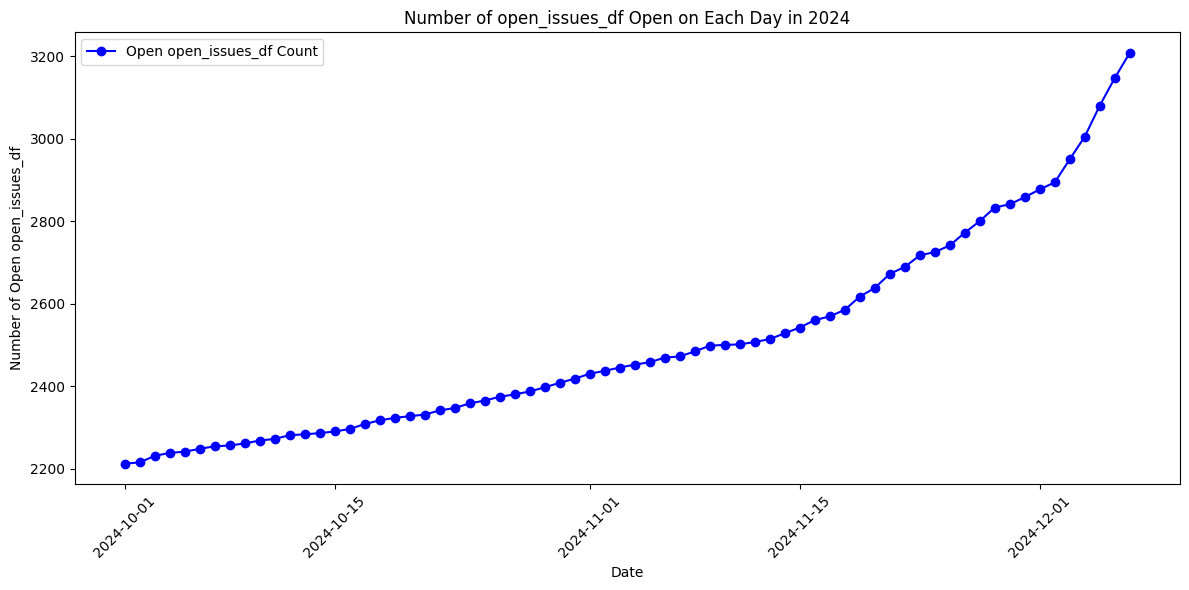

In [80]:
stg_open_issues_df_df = open_issues_df
# Ensure 'issue_created_at' and 'issue_closed_at' are in datetime format
stg_open_issues_df_df['issue_created_at'] = pd.to_datetime(stg_open_issues_df_df['issue_created_at'])
stg_open_issues_df_df['issue_closed_at'] = pd.to_datetime(stg_open_issues_df_df['issue_closed_at'], errors='coerce')

# Filter for open_issues_df created in 2024
stg_open_issues_df_df = stg_open_issues_df_df[stg_open_issues_df_df['issue_created_at'].dt.year == 2024]

# Create a date range for every day in 2024
date_range = pd.date_range(start='2024-10-01', end='2024-12-07', freq='D')

# Initialize a list to store the count of open open_issues_df per day
open_open_issues_df_per_day = []

# For each day in the 2024 date range
for date in date_range:
    # Count open_issues_df where created_at <= date and (closed_at >= date or is NaT if still open)
    open_open_issues_df = stg_open_issues_df_df[
        (stg_open_issues_df_df['issue_created_at'] <= date) & 
        ((stg_open_issues_df_df['issue_closed_at'].isna()) | (stg_open_issues_df_df['issue_closed_at'] >= date))
    ]
    
    # Append the count of open open_issues_df to the list
    open_open_issues_df_per_day.append(len(open_open_issues_df))

# Create a DataFrame with the date range and the corresponding open open_issues_df count
daily_open_issues_df = pd.DataFrame({
    'date': date_range,
    'open_open_issues_df_count': open_open_issues_df_per_day
})

# Display the first few rows to confirm
daily_open_issues_df.head()

# print(daily_open_issues_df)
# Plotting the chart
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(daily_open_issues_df['date'], daily_open_issues_df['open_open_issues_df_count'], label='Open open_issues_df Count', color='b', marker='o')

plt.title('Number of open_issues_df Open on Each Day in 2024')
plt.xlabel('Date')
plt.ylabel('Number of Open open_issues_df')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()

# Show the plot
plt.show()

# Heatmap of open 311 requests

In [81]:

# Create a base map centered around the average latitude and longitude
map_center = [open_issues_df['latitude'].mean(), open_issues_df['longitude'].mean()]
m = folium.Map(location=map_center, zoom_start=12)

# Filter out rows with missing latitude or longitude
heat_data = open_issues_df.dropna(subset=['latitude', 'longitude'])

# Prepare the data for the heatmap: a list of [latitude, longitude] pairs
heat_data_list = heat_data[['latitude', 'longitude']].values.tolist()

# Add a heatmap layer
HeatMap(heat_data_list).add_to(m)

# Display the map (in a Jupyter Notebook, the map will render interactively)
m


# Heatmap of open homelessness requests

In [82]:
import folium
from folium.plugins import HeatMap
import pandas as pd

# Filter for the rows where 'is_homeless_related' is True
homeless_related_df = open_issues_df[open_issues_df['is_homeless_related'] == True].copy()  # Use .copy() to ensure it's a new DataFrame

# Calculate the number of homelessness-related open_issues_df
num_homeless_open_issues_df = homeless_related_df.shape[0]

# Calculate the median age of homelessness-related open_issues_df
homeless_related_df['ticket_age_days'] = (pd.Timestamp.now() - homeless_related_df['issue_created_at']).dt.days

# Find the assignee with the most open tickets
homeless_related_df['assignee_name'] = homeless_related_df['assignee'].apply(lambda x: x['name'] if isinstance(x, dict) else None)

# Calculate the assignee counts
assignee_counts = homeless_related_df['assignee_name'].value_counts()

# Create a description with the calculated statistics
description = f"""
<h3>Homelessness-Related open_issues_df</h3>
<p><strong>Number of open_issues_df:</strong> {num_homeless_open_issues_df}</p>
<p><strong>Median Age of open_issues_df (days):</strong> {homeless_related_df['ticket_age_days'].median()}</p>
<p><strong>Assignees with Most Open Tickets:</strong></p>
<p>{assignee_counts.index[0]} ({assignee_counts.iloc[0]})</p>
<p>{assignee_counts.index[1]} ({assignee_counts.iloc[1]})</p>
<p>{assignee_counts.index[2]} ({assignee_counts.iloc[2]})</p>
<p>{assignee_counts.index[3]} ({assignee_counts.iloc[3]})</p>
<p>{assignee_counts.index[4]} ({assignee_counts.iloc[4]})</p>
<br>
<p></p>
"""


In [83]:
# Display the text description
from IPython.display import display, HTML
display(HTML(description))


In [84]:
# Create a base map centered around the average latitude and longitude
map_center = [homeless_related_df['latitude'].mean(), homeless_related_df['longitude'].mean()]
m = folium.Map(location=map_center, zoom_start=12)

# Filter out rows with missing latitude or longitude
heat_data = homeless_related_df.dropna(subset=['latitude', 'longitude'])

# Prepare the data for the heatmap: a list of [latitude, longitude] pairs
heat_data_list = heat_data[['latitude', 'longitude']].values.tolist()

# Add a heatmap layer
HeatMap(heat_data_list).add_to(m)

# Display the map
m

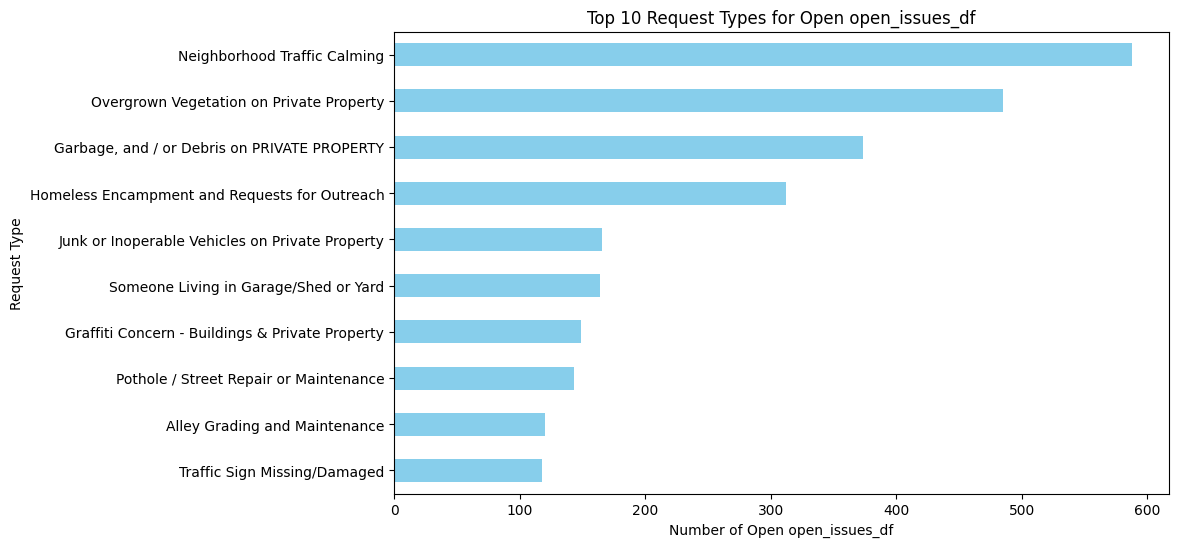

In [85]:
top_request_types.head(10).sort_values(ascending=True).plot(kind='barh', figsize=(10, 6), color='skyblue')
plt.title('Top 10 Request Types for Open open_issues_df')
plt.xlabel('Number of Open open_issues_df')
plt.ylabel('Request Type')
plt.show()


In [86]:
# Add a new column 'is_traffic_calming' based on the 'request_type_title' column
open_open_issues_df_NTC_df = open_issues_df.copy()

# Filter the DataFrame for "Neighborhood Traffic Calming" requests
traffic_calming_df = open_open_issues_df_NTC_df[open_open_issues_df_NTC_df['request_type_title'] == 'Neighborhood Traffic Calming']

# Calculate the number of days since the issue was created (aging) using .loc to avoid SettingWithCopyWarning
traffic_calming_df.loc[:, 'ticket_age_days'] = (pd.Timestamp.now() - traffic_calming_df['issue_created_at']).dt.days

# Initialize the map centered around the average latitude and longitude
map_center = [traffic_calming_df['latitude'].mean(), traffic_calming_df['longitude'].mean()]
m = folium.Map(location=map_center, zoom_start=12)

# Add markers for each "Neighborhood Traffic Calming" issue
for _, row in traffic_calming_df.iterrows():
    # Prepare the popup content, truncating the description to 375 characters
    description = row['issue_description']
    if len(description) > 150:
        description = description[:150] + "..."
    
    popup_content = f"""
    <strong>Request Type:</strong> {row['request_type_title']}<br>
    <strong>Description:</strong> {description}<br>
    <strong>Aging (days):</strong> {row['ticket_age_days']} days
    """
    
    # Create the marker with the popup
    folium.Marker(
        location=[row['latitude'], row['longitude']],
        popup=popup_content,
        icon=folium.Icon(color='blue', icon='info-sign')
    ).add_to(m)

# Display the map
m


# Heatmaps

In [87]:
import folium
from folium.plugins import HeatMap
import pandas as pd
from IPython.display import display, HTML

# Create a base map centered around the average latitude and longitude
map_center = [open_issues_df['latitude'].mean(), open_issues_df['longitude'].mean()]

# HTML string to contain the maps
html_output = ""

# Get counts of each request type
request_type_counts = open_issues_df['request_type_title'].value_counts()

# Sort the request types by count (most to least)
sorted_request_types = request_type_counts.sort_values(ascending=False).index

# Loop through each sorted 'request_type_title'
for i, request_type in enumerate(sorted_request_types):
    # Filter the data for the current request type
    filtered_data = open_issues_df[open_issues_df['request_type_title'] == request_type]
    
    # Filter out rows with missing latitude or longitude
    heat_data = filtered_data.dropna(subset=['latitude', 'longitude'])
    
    # Prepare the data for the heatmap: a list of [latitude, longitude] pairs
    heat_data_list = heat_data[['latitude', 'longitude']].values.tolist()

    # Create a map for the current request type with larger size
    m = folium.Map(location=map_center, zoom_start=11.75, width='100%', height='400px')
    
    # Add heatmap layer for the current request type
    HeatMap(heat_data_list).add_to(m)

    # Get the count for the current request type
    count = request_type_counts[request_type]

    # Create the title for the current request type with count
    title = f"<h3 style='font-size: 18px; text-align: center;'>{request_type} ({count} open_issues_df)</h3>"
    
    # Add the title and map to the HTML output, two per row
    if i % 2 == 0:
        # Start a new row (for the first map in each pair)
        html_output += f"<div style='display: flex; justify-content: space-between; width: 100%;'>"
    
    # Add the map and title as a flex item
    html_output += f"""
    <div style="flex: 1; margin: 10px;">
        {title}
        {m._repr_html_()}  <!-- This embeds the map directly in the notebook -->
    </div>
    """
    
    if i % 2 == 1:
        # Close the row after the second map in each pair
        html_output += "</div>"

# Display the maps with titles and counts two per row in the notebook
display(HTML(html_output))


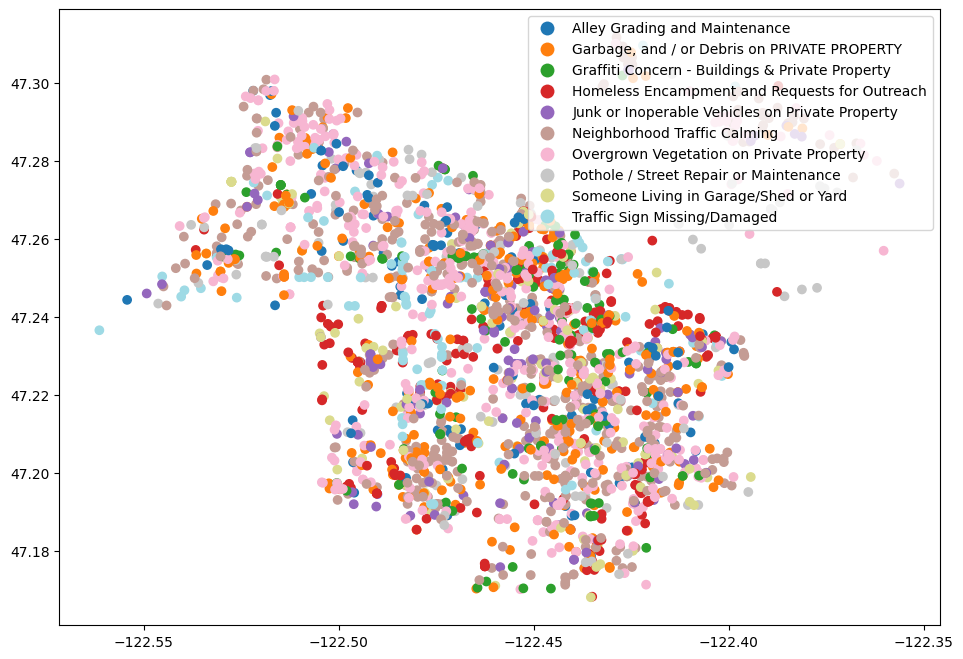

In [88]:
import geopandas as gpd
import matplotlib.pyplot as plt

# Get the top 10 most frequent 'request_type_title'
top_10_open_issues_df = open_issues_df['request_type_title'].value_counts().head(10).index

# Filter the DataFrame to only include the top 10 open_issues_df
top_10_open_issues_df_df = open_issues_df[open_issues_df['request_type_title'].isin(top_10_open_issues_df)]

# Convert to a GeoDataFrame
gdf = gpd.GeoDataFrame(top_10_open_issues_df_df, geometry=gpd.points_from_xy(top_10_open_issues_df_df['longitude'], top_10_open_issues_df_df['latitude']))

# Plot the data with a more varied color map
gdf.plot(column='request_type_title', cmap='tab20', legend=True, figsize=(12, 8))

# Show the plot
plt.show()


In [89]:
import folium
import pandas as pd

# Group by 'request_type_title' and calculate the median latitude and longitude
median_lat_lng = open_issues_df.groupby('request_type_title').agg(
    median_lat=('latitude', 'median'),
    median_lng=('longitude', 'median'),
    count=('latitude', 'size')
).reset_index()

# Sort by count to get the top 10 request types
top_10_request_types = median_lat_lng.sort_values('count', ascending=False).head(10)

# Initialize a folium map centered around the average latitude and longitude of the top 10
m = folium.Map(location=[top_10_request_types['median_lat'].mean(), top_10_request_types['median_lng'].mean()], zoom_start=12)

# Add markers for the top 10 request types with their median latitudes and longitudes
for _, row in top_10_request_types.iterrows():
    folium.Marker(
        location=[row['median_lat'], row['median_lng']],
        popup=f"Request Type: {row['request_type_title']}<br>Count: {row['count']}",
        icon=folium.Icon(color='blue', icon='info-sign')
    ).add_to(m)

# Display the map
m


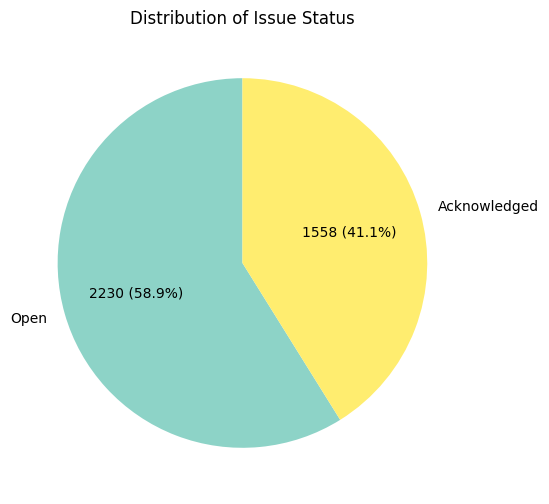

In [90]:
import matplotlib.pyplot as plt

# Get the counts of each issue status
status_counts = open_issues_df["issue_status"].value_counts()

# Function to display both count and percentage
def func(pct, allvals):
    absolute = int(pct / 100.*sum(allvals))
    return f"{absolute} ({pct:.1f}%)"

# Plotting the pie chart
plt.figure(figsize=(8, 8))
status_counts.plot(kind='pie', autopct=lambda pct: func(pct, status_counts), startangle=90, cmap='Set3', figsize=(10, 6))
plt.title('Distribution of Issue Status')
plt.ylabel('')  # Remove the y-label for aesthetics
plt.show()


In [118]:
import numpy as np
import folium
import matplotlib.pyplot as plt

mapfol_df = open_issues_df

# Define grid size
grid_size = 0.01  # Adjust for finer/larger grids

# Add grid cell identifiers to the DataFrame
mapfol_df['grid_lat'] = (mapfol_df['latitude'] // grid_size) * grid_size
mapfol_df['grid_lon'] = (mapfol_df['longitude'] // grid_size) * grid_size
mapfol_df['grid_id'] = mapfol_df['grid_lat'].astype(str) + ',' + mapfol_df['grid_lon'].astype(str)

# Calculate counts and proportions per grid
grid_summary = (
    mapfol_df.groupby(['grid_id', 'request_type_title'])
    .size()
    .reset_index(name='count')
    .merge(
        mapfol_df.groupby('grid_id').size().reset_index(name='total_count'),
        on='grid_id'
    )
)
grid_summary['proportion'] = grid_summary['count'] / grid_summary['total_count']

# Find the dominant issue type per grid
dominant_issue = grid_summary.loc[
    grid_summary.groupby('grid_id')['proportion'].idxmax()
]

# Include grid_lat and grid_lon in the dominant_issue DataFrame
dominant_issue = dominant_issue.merge(
    mapfol_df[['grid_id', 'grid_lat', 'grid_lon']].drop_duplicates(),
    on='grid_id',
    how='left'
)

# Merge back to mapfol_df DataFrame for mapping
mapfol_df = mapfol_df.merge(
    dominant_issue[['grid_id', 'request_type_title']].rename(columns={'request_type_title': 'dominant_issue'}),
    on='grid_id',
    how='left'
)

# Create base map
map_center = [mapfol_df['latitude'].mean(), mapfol_df['longitude'].mean()]
map = folium.Map(location=map_center, zoom_start=12)

# Generate unique colors for each request_type_title
titles_arr = open_issues_df['request_type_title'].unique()
color_map = {title: plt.cm.tab10(i % 10) for i, title in enumerate(titles_arr)}

# Convert RGBA colors to hex for Folium
color_map_hex = {title: f"#{int(r*255):02x}{int(g*255):02x}{int(b*255):02x}" 
                 for title, (r, g, b, _) in color_map.items()}

# Add grid cells with dynamic colors
for _, row in dominant_issue.iterrows():
    issue_type = row['request_type_title']
    folium.Rectangle(
        bounds=[
            [row['grid_lat'], row['grid_lon']],
            [row['grid_lat'] + grid_size, row['grid_lon'] + grid_size]
        ],
        color=color_map_hex[issue_type],
        fill=True,
        fill_opacity=0.5,
        popup=f"{issue_type} ({row['proportion']:.1%})"
    ).add_to(map)

# Display the map
map
